### The New system equations are (w/o steering angle):  
θ(t) = θ(t-Δt) + Δθ(t)  
x(t) = x(t-Δt) + v * cos(θ(t)) * Δt  
y(t) = y(t-Δt) + v * sin(θ(t)) * Δt  


& Values of x(t=0), y(t=0) and θ(t=0) are definite/constants and are given. For simplicity, let's assume x(t=0), y(t=0) and θ(t=0) to be 0 while the vehicle is moving with a constant speed of 1.    
$ Assuming value of Δθ(t) to be derived from Gaussian(0, 1).  

In [1]:
# I know that the distribution is uniform(-np.pi/3, +np.pi/3)
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal, getcontext

# Set the precision (number of significant digits)
getcontext().prec = 25

In [2]:
# Function for the kinematic bicycle model
# def kinematic_bicycle_model(x, y, change_in_theta, v, a, dt):
def kinematic_bicycle_model(x_prev, y_prev, change_in_theta_distrib):
    # This function takes into account the previous x and y coordinates
    # (which are nothing but the mean of their respective distributions)
    # and then returns the newly generated distributions on the basis of 
    # given distribution of change in heading angle.
    dt = 0.1
    v = 1
    # x_new & y_new are the new distributions
    x_new_distrib = v * np.cos(change_in_theta_distrib) * dt
    y_new_distrib = v * np.sin(change_in_theta_distrib) * dt
    # v += a * dt
    # Assuming no effect of acceleration and constant velocity equal to 1.
    # Round the distributions to 2 decimal places
    x_new_distrib = np.round(x_new_distrib, 25)
    y_new_distrib = np.round(y_new_distrib, 25)
    return x_new_distrib, y_new_distrib

def x_distribution(current_x_distr, theta_distribution) -> list :
    return current_x_distr + np.cos(theta_distribution)

def y_distribution(current_y_distr, theta_distribution) -> list :
    return current_y_distr + np.sin(theta_distribution)


distrib => List of bootstrapped samples   
dict => Dictionary containing unique keys and their respective probabilities.

In [3]:
# Function which returns the mean and variance of the sampled list.
def staticalMeasures (List):
    mean_sample_X = statistics.mean(List)
    # mode_sample_X = statistics.mode(List)
    # median_sample_X = statistics.median(List)
    std_sample_X = statistics.stdev(List)
    return mean_sample_X, std_sample_X

# Function which generates dictionary (item:probability) from the given sampled list from the previous distribution.
# def generateProbDictionary(Array) -> dict :
#     dict_X = {}
#     for i in Array :
#         if (i not in dict_X) :
#             dict_X[i] = np.count_nonzero(Array == i)/len(Array)

#     sorted_items = sorted(dict_X.items())
#     # Create a new dictionary from the sorted list of key-value pairs
#     sorted_dict = dict(sorted_items)
#     return sorted_dict

def generateProbDictionary(array) -> dict:
    # Use np.unique with return_counts to get unique values and their counts
    unique_values, counts = np.unique(array, return_counts=True)
    # Calculate probabilities
    probabilities = counts / len(array)
    # Create a dictionary from unique values and their probabilities
    prob_dict = dict(zip(unique_values, probabilities))
    # Sort the dictionary by keys
    sorted_prob_dict = dict(sorted(prob_dict.items()))
    return sorted_prob_dict

# Function which samples values (chooses values) from a given dictionary of values on the basis of the probability assigned to them.
def returnBootstrapSample (dictionary, size_of_list)-> list :
    # Create a list of numbers and their weights
    numbers = list(dictionary.keys())
    weights = list(dictionary.values())

    # Generate a list of 1000(size_of_list) numbers based on the probabilities
    result_list = random.choices(numbers, weights=weights, k=size_of_list)
    return result_list

# def calculateMSE (D1, D2) :
#     squared_diffs = [(x - y) ** 2 for x, y in zip(D1.keys(), D2.keys())]
#     MSE = sum(diff * list(D1.values())[i] * list(D2.values())[i] for i, diff in enumerate(squared_diffs))/len(D1)
#     return Decimal(MSE)

def calculateMSE(dict1, dict2):
    # Get all unique keys from both dictionaries
    all_keys = set(dict1.keys()).union(set(dict2.keys()))
    
    mse = 0
    for key in all_keys:
        # Get the probability values for the current key from both dictionaries
        prob1 = dict1.get(key, 0)
        prob2 = dict2.get(key, 0)
        
        # Compute the squared difference for the current key
        squared_difference = (prob1 - prob2) ** 2
        
        # Add the squared difference to the cumulative MSE
        mse += squared_difference
    
    # Calculate the mean of the squared differences
    mse /= len(all_keys)
    
    return Decimal(mse)

def printObservation (sample_X) :
    mean_sample_X, std_sample_X = staticalMeasures (sample_X)
    print ("Mean : {}, Std. Deviation : {}".format(mean_sample_X, round(std_sample_X,2)))

# For plotting 1 graph only
def plot(given_dict, mse, confidence_level=95):
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract the numbers and probabilities into separate lists
    numbers = list(given_dict.keys())
    probabilities = list(given_dict.values())

    # Create a figure and axis objects
    fig, ax = plt.subplots()

    # Plot the data as a bar chart
    ax.bar(numbers, probabilities)

    # Set the title and axis labels
    ax.set_title("Sample vs Probability")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Probability")
    
    if mse != "NO NEED":
        ax.axvline(x=mse, color='r', linestyle='--', linewidth=2, label="MSE")

    # CDF :
    cumulative_probabilities = np.cumsum(probabilities)

    # Determining the confidence interval
    lower_bound = (100 - confidence_level) / 2
    upper_bound = 100 - lower_bound

    # Finding the indices for the confidence interval bounds
    lower_index = np.searchsorted(cumulative_probabilities, lower_bound / 100.0)
    upper_index = np.searchsorted(cumulative_probabilities, upper_bound / 100.0)

    # Drawing vertical lines for the confidence interval bounds
    if lower_index < len(numbers):
        ax.axvline(x=numbers[lower_index], color='g', linestyle='--', linewidth=2, label=f'{lower_bound}% Confidence Interval')
    if upper_index < len(numbers):
        ax.axvline(x=numbers[upper_index], color='g', linestyle='--', linewidth=2, label=f'{upper_bound}% Confidence Interval')
    # Add a legend
    ax.legend()
    plt.show()

def plot_three_distributions(x_dict, y_dict, theta_dict, mse, confidence_level=95):
    def plot_single_distribution(ax, given_dict, title, mean_value=None, mse_value=None, confidence_level=95):
        numbers = list(given_dict.keys())
        probabilities = list(given_dict.values())
        
        ax.bar(numbers, probabilities)
        ax.set_title(title)
        ax.set_xlabel("Sample")
        ax.set_ylabel("Probability")
        
        if mean_value is not None:
            ax.axvline(x=mean_value, color='b', linestyle='--', linewidth=2, label="Mean")
            ax.text(mean_value, max(probabilities), f'Mean: {mean_value:.2f}', color='b', ha='center')
        
        if mse_value is not None:
            ax.axvline(x=mse_value, color='r', linestyle='--', linewidth=2, label="MSE")
            ax.text(mse_value, max(probabilities), f'MSE: {mse_value:.2f}', color='r', ha='center')
        
        cumulative_probabilities = np.cumsum(probabilities)
        lower_bound = (100 - confidence_level) / 2
        upper_bound = 100 - lower_bound
        
        lower_index = np.searchsorted(cumulative_probabilities, lower_bound / 100.0)
        upper_index = np.searchsorted(cumulative_probabilities, upper_bound / 100.0)
        
        if lower_index < len(numbers):
            ax.axvline(x=numbers[lower_index], color='g', linestyle='--', linewidth=2, label=f'{lower_bound}% Confidence Interval')
        if upper_index < len(numbers):
            ax.axvline(x=numbers[upper_index], color='g', linestyle='--', linewidth=2, label=f'{upper_bound}% Confidence Interval')
        
        ax.legend()
        
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot for x_dict
    x_mean = np.mean(list(x_dict.keys()))
    plot_single_distribution(axs[0], x_dict, "X Distribution", mean_value=x_mean, confidence_level=confidence_level)
    
    # Plot for y_dict
    y_mean = np.mean(list(y_dict.keys()))
    plot_single_distribution(axs[1], y_dict, "Y Distribution", mean_value=y_mean, confidence_level=confidence_level)
    
    # Plot for theta_dict
    plot_single_distribution(axs[2], theta_dict, "Theta Distribution", mse_value=mse, confidence_level=confidence_level)
    
    plt.tight_layout()
    plt.show()

Setting the initial conditions: 

Observed Samples : 
[-1.27380135, -0.0106662654, -0.806624039, 0.868349917, 0.406497318, 0.968694057, 1.57416605, -1.84575969, -1.43777724, 0.45494379, -0.0365391035, -0.962010223, -0.977545715, 1.12982518, 0.209235495, 0.147750511, 0.667199456, 0.247376445, 0.409715614, -0.878724561, -0.0184813448, 1.5609968, 1.18693333, -1.27988952, -1.44038674, 1.65897557, 0.0320768306, -0.59840929, -0.727382239, -0.963673016, 0.788281243, 1.52885322, 1.12308847, -0.6012943, -1.23560384, -0.973184237, -1.14650667, 0.342530947, 0.248819529, -0.0413352204, -0.692345489, -0.653838105, 0.58638087, -1.72597858, 0.446534658, -1.58389084, 0.338668584, 1.86218389, -2.12084003, 2.30220795, 0.319028277, -1.6293306, -2.1362601, 1.70330067, -1.45688962, -1.19813223, -0.749533183, 0.69051661, -1.92060066, -1.88187916, 1.19557868, -0.432663517, -0.995835481, -0.368220773, 1.031507, -0.0836067621, -1.63392795, -0.402863901, 1.52795267, -2.06905446, 0.130153289, 0.00784109972, 0.57671199, 1.31075093, 0.0254620199, 

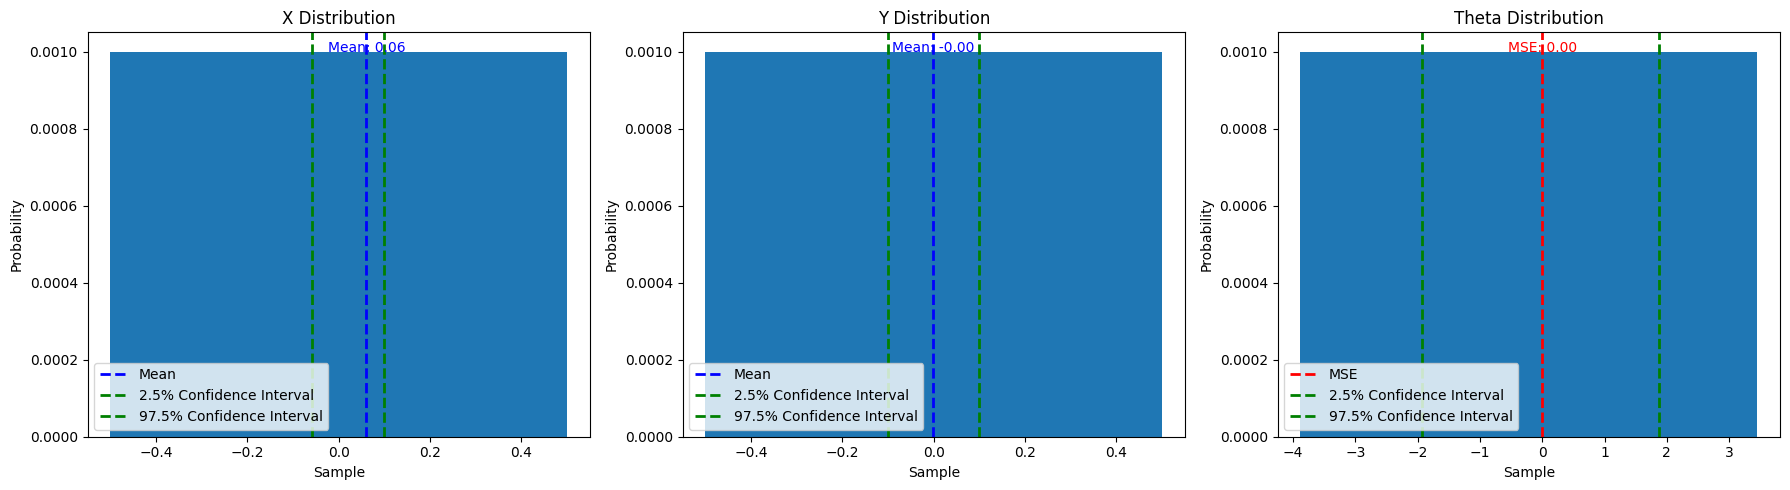

MSE :  0.00000105000000000000731108424668891476727594636031426489353179931640625
[0.459368880422264, 0.400537942422264, 0.529387191422264, -0.713645351577736, 0.5690602424222639]
[0.08884112 0.09138649 0.08541188 0.0767355  0.08328191]
[ 0.04590485  0.04060184  0.05200779 -0.06412225  0.05535453]


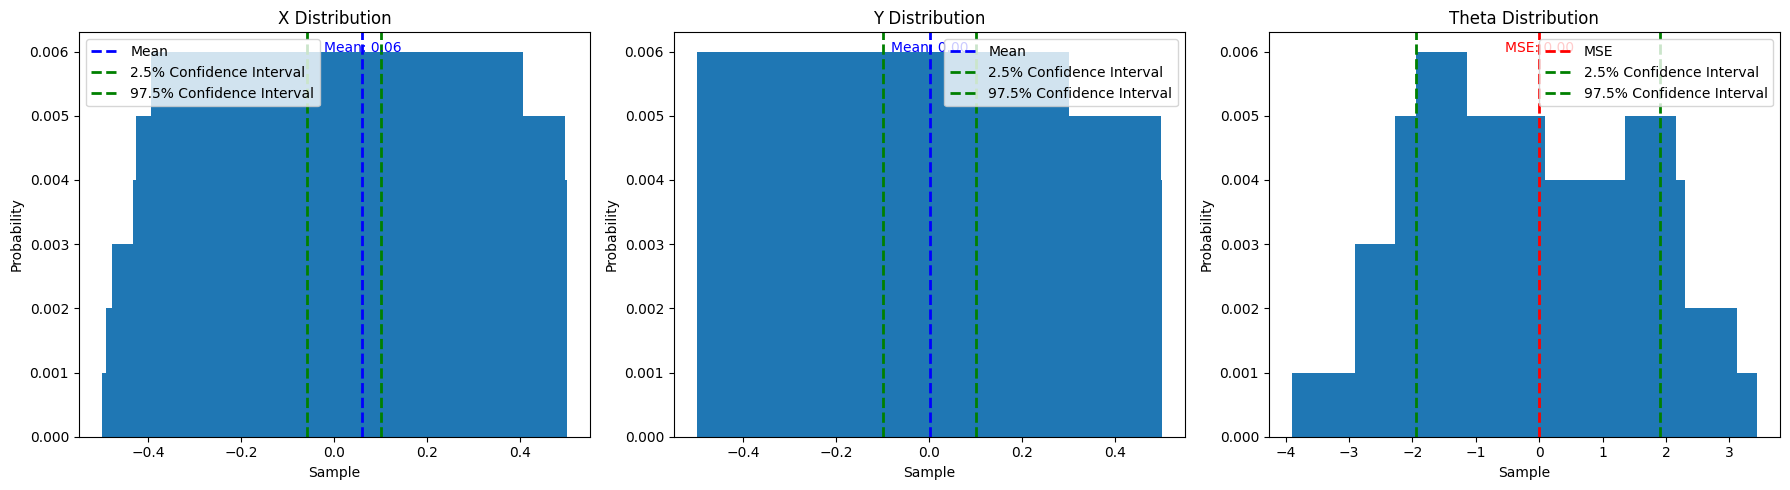

MSE :  0.000001676190476190480884227597575819590502987921354360878467559814453125
[-0.268585509372172, -0.09755765247217202, -1.077558359372172, 1.149051240627828, 1.785028020627828]
[ 0.0970733   0.09974447  0.04962651  0.03854465 -0.02379796]
[-0.02401613 -0.00714433 -0.0868171   0.09227302  0.09712702]


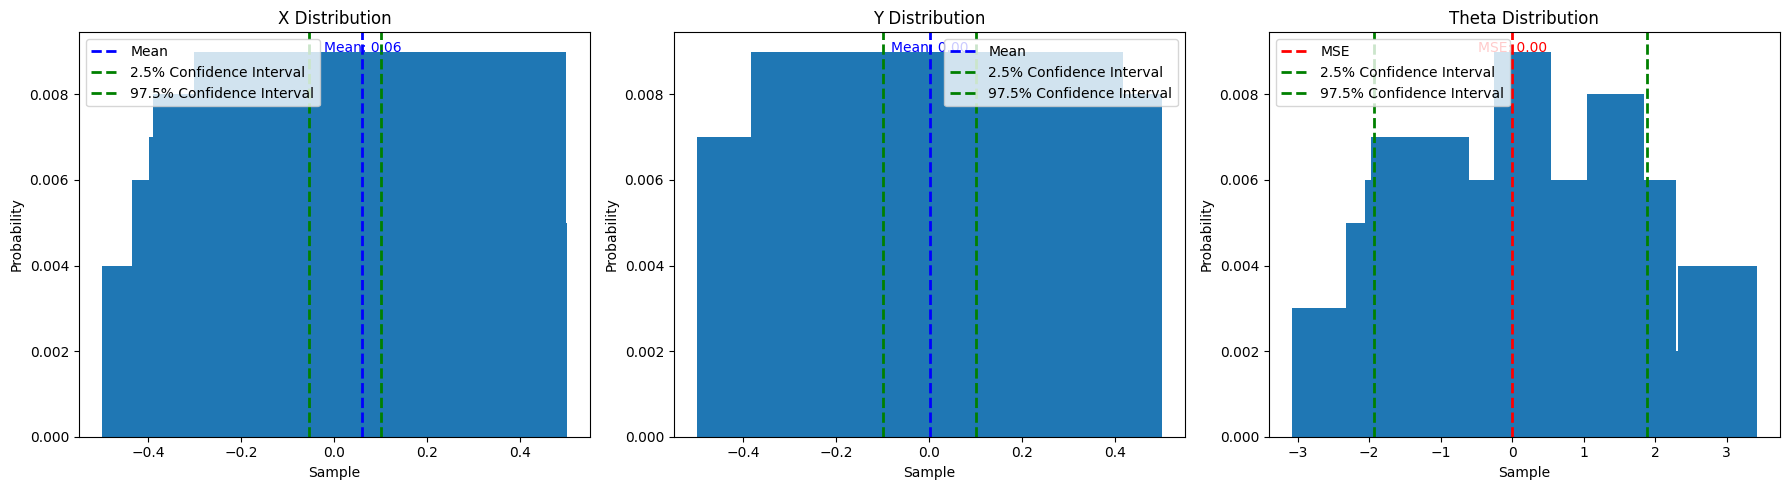

MSE :  0.0000020172413793103505450497216211491746662431978620588779449462890625
[-0.06161562304423199, 0.263640322755768, -0.35180390824423197, 0.03158909585576802, -1.3065779882442319]
[0.09998292 0.09533126 0.09527386 0.09972095 0.03025364]
[-0.00184803  0.03019854 -0.03037914  0.00746539 -0.09531378]


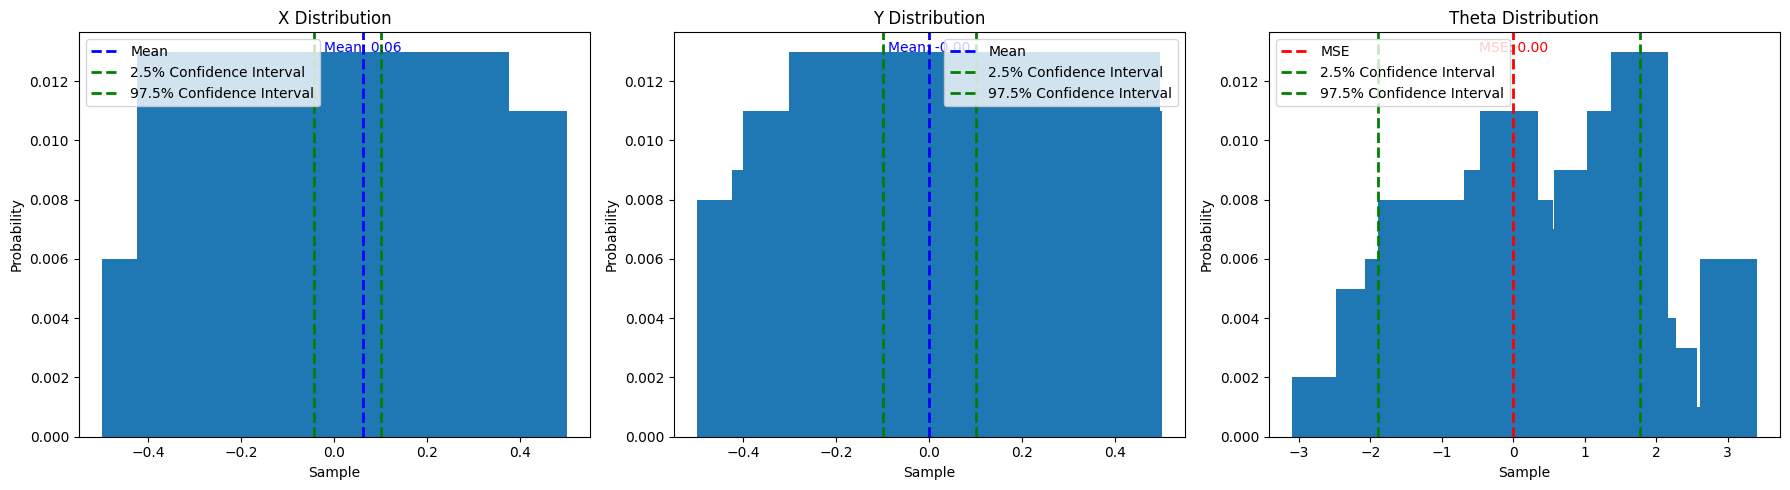

MSE :  0.0000028418230563002666553564477813775823733521974645555019378662109375
[1.668414910332108, 1.668414910332108, 1.469899770332108, 0.21118445533210806, -0.5169884026678919]
[-0.00960172 -0.00960172  0.01021712  0.09780869  0.08685925]
[ 0.09953797  0.09953797  0.09947668  0.02081971 -0.04955271]


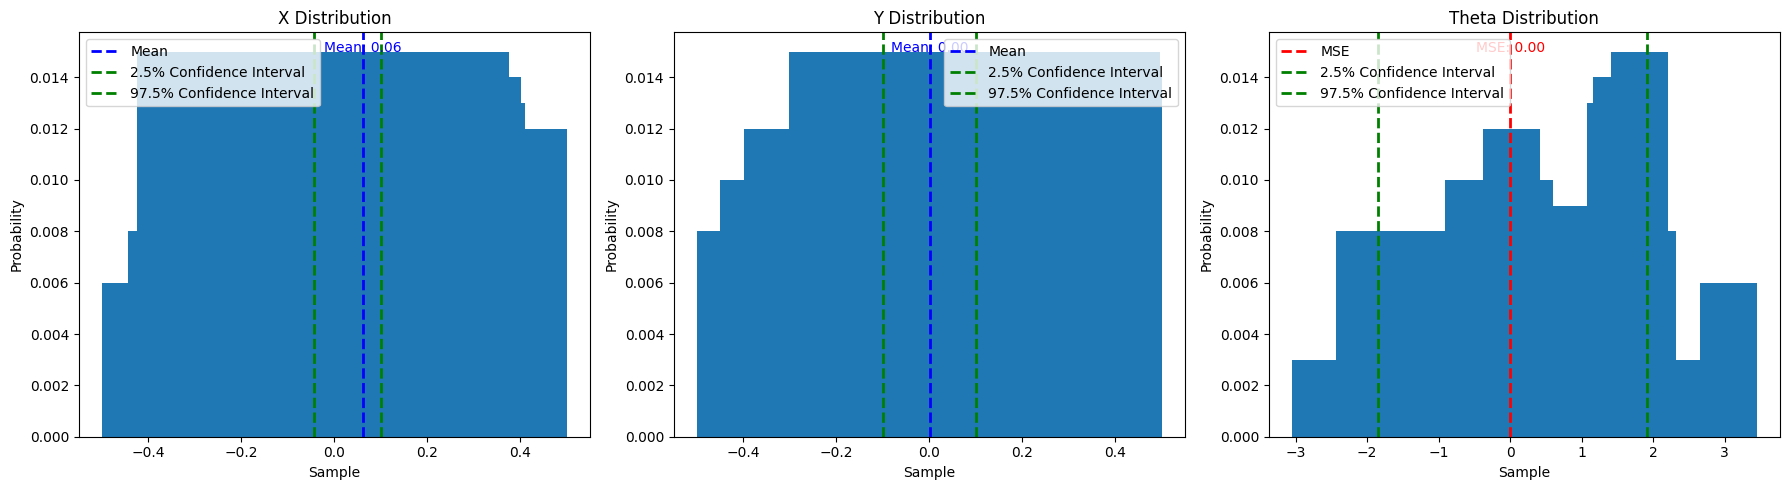

MSE :  0.00000326349206349206375445582035965674805311209638603031635284423828125
[-1.365040130808862, -0.454898251808862, 0.612262848191138, 0.447155996191138, -0.224730656808862]
[0.01300403 0.08626833 0.08592901 0.09316715 0.09553137]
[-0.09915087 -0.05057446  0.05114886  0.03633018 -0.0295594 ]


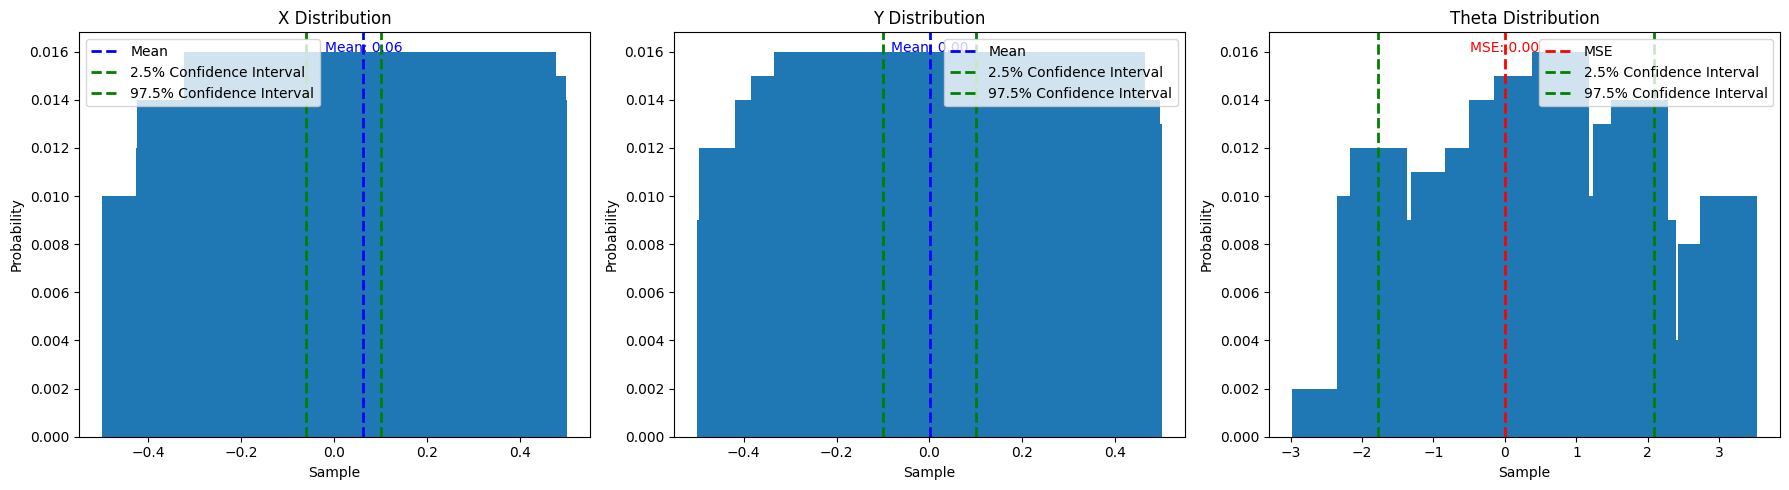

MSE :  0.0000043000000000000071110760509196513368124215048737823963165283203125
[-0.806964875153912, 0.702872230846088, 1.116230047846088, 0.537765378846088, -0.517152931153912]
[0.05628877 0.08592901 0.05814601 0.09316715 0.07756141]
[-0.08265334  0.05114886  0.08135749  0.03633018 -0.06312074]


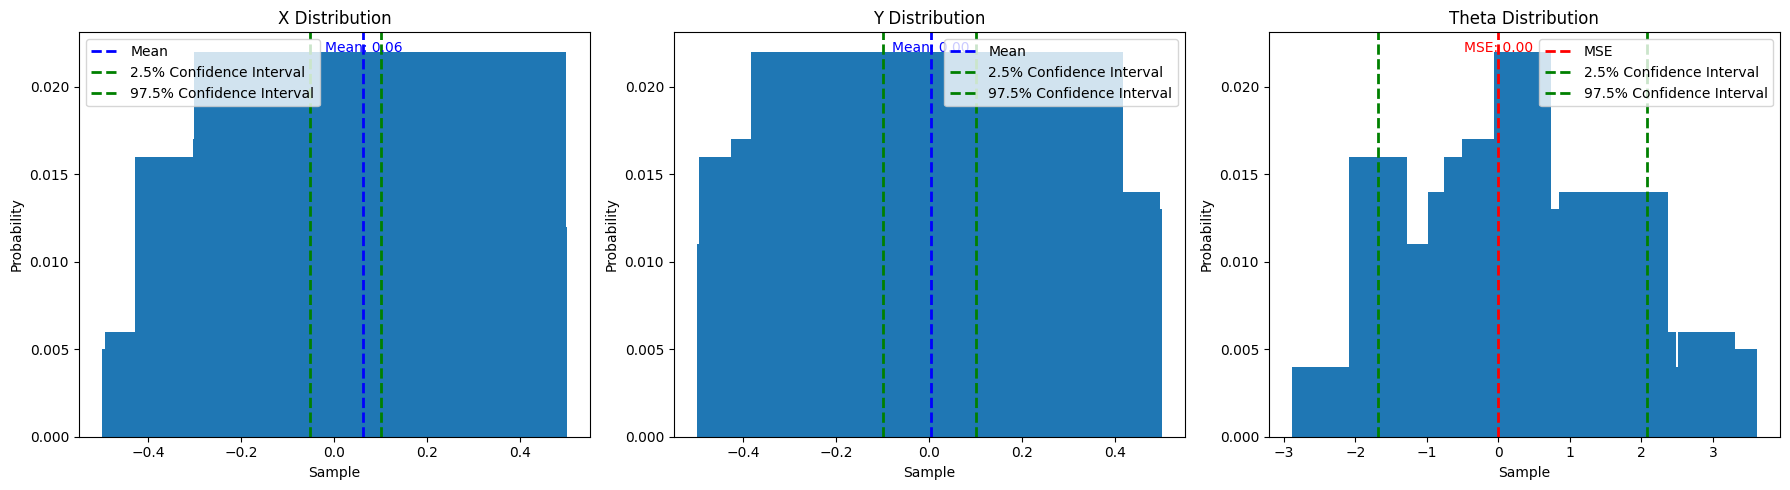

MSE :  0.0000038173913043478297166537401008401531044000876136124134063720703125
[1.781393194284308, -1.358139045715692, 3.2691500842843078, 0.726218320284308, -0.526060951715692]
[ 0.00097994 -0.0007739  -0.09956936  0.08747765  0.07340991]
[ 0.0999952  -0.09999701  0.00927057  0.04845266 -0.06790424]


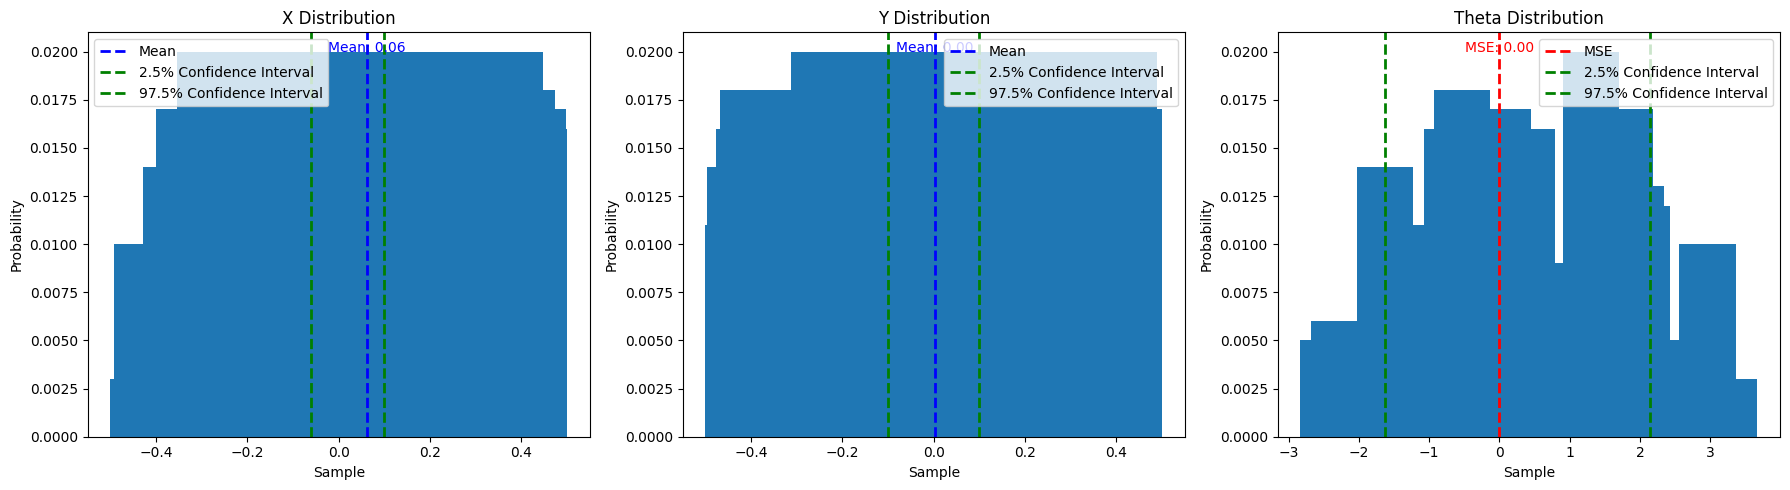

MSE :  0.0000052676056338028158935516721828040687114480533637106418609619140625
[-0.4476616153221721, 1.583933885677828, 1.730087965677828, -0.015085854322172021, 0.14258050167782796]
[0.0758816  0.0245954  0.01021712 0.09619547 0.09929206]
[-0.0651305   0.09692815  0.09947668 -0.02732089 -0.01187798]


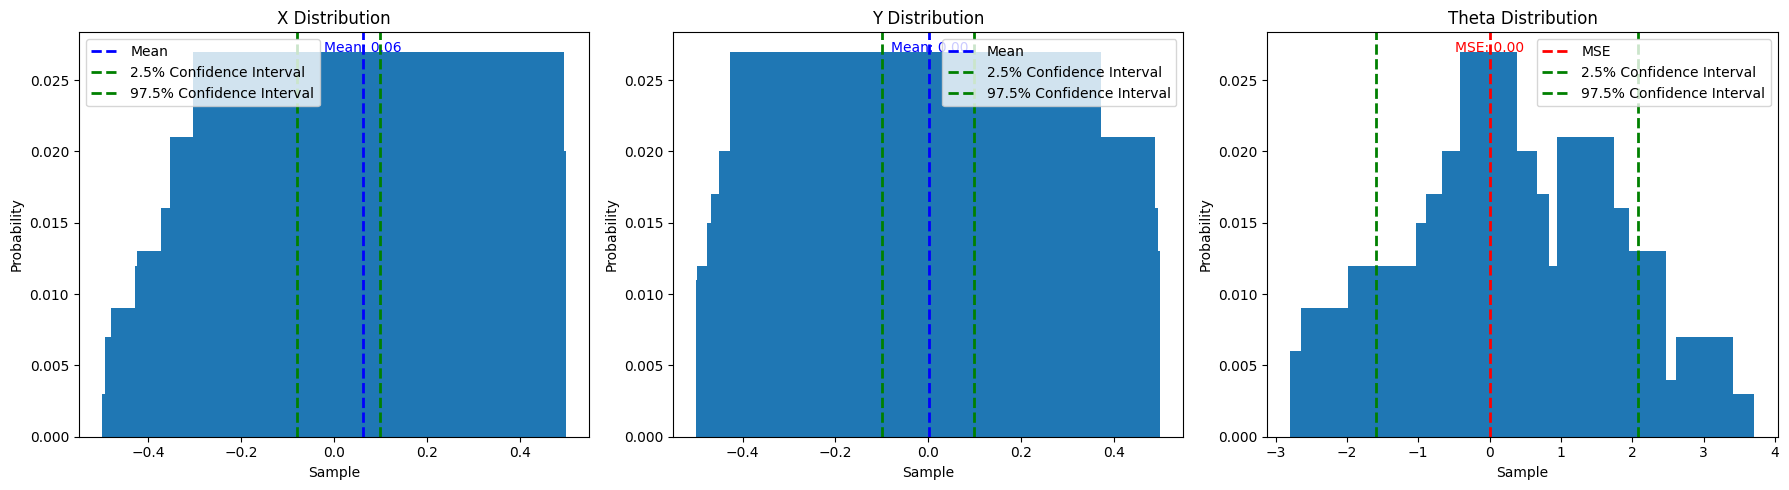

MSE :  0.0000061770833333333287546752787822157415575929917395114898681640625
[0.413484102189028, 0.08278395818902798, -0.9304414908109719, -1.228289080810972, 0.270454734099028]
[0.0989391  0.09829534 0.0364098  0.00747467 0.09999962]
[ 0.01452774 -0.01838549 -0.09313607 -0.09972026  0.0002764 ]


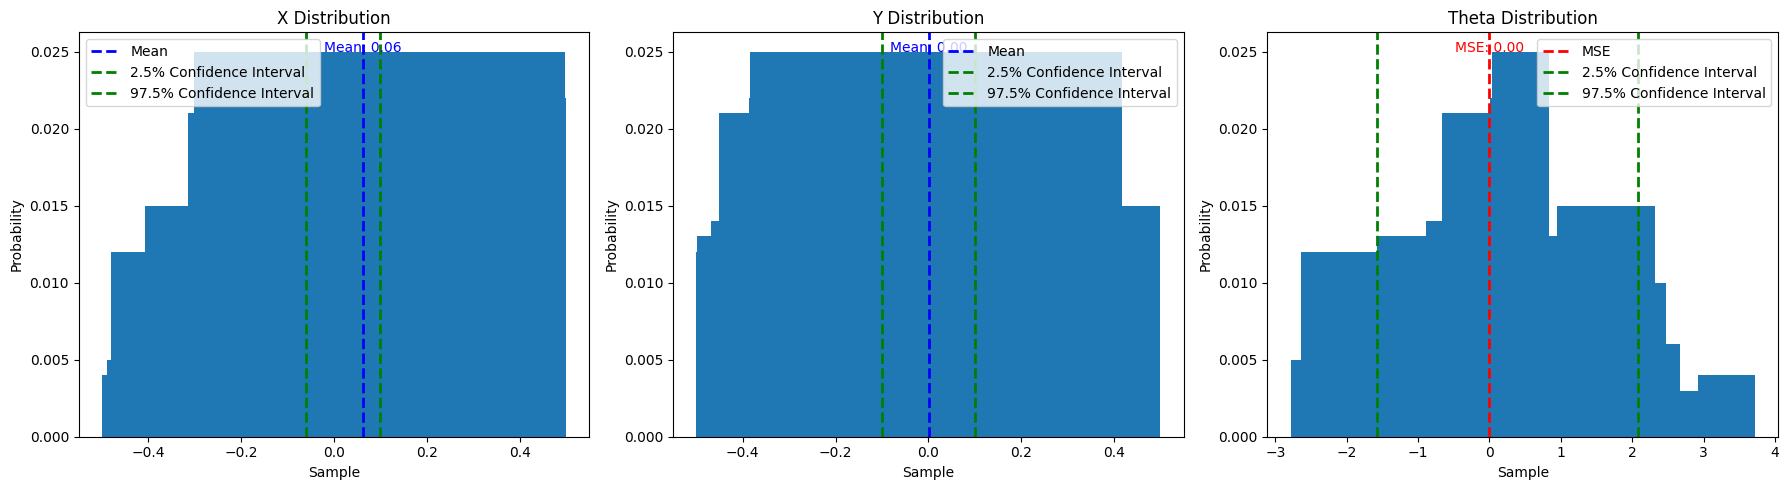

MSE :  0.000005771428571428574011013996891694688429197412915527820587158203125
[-0.6608942537004121, 1.297981746299588, 0.48041332129958797, -0.7022388007004121, -0.8476059137004122]
[0.05965696 0.05171319 0.09780869 0.05628877 0.04372228]
[-0.08025613  0.08559057  0.02081971 -0.08265334 -0.08993532]


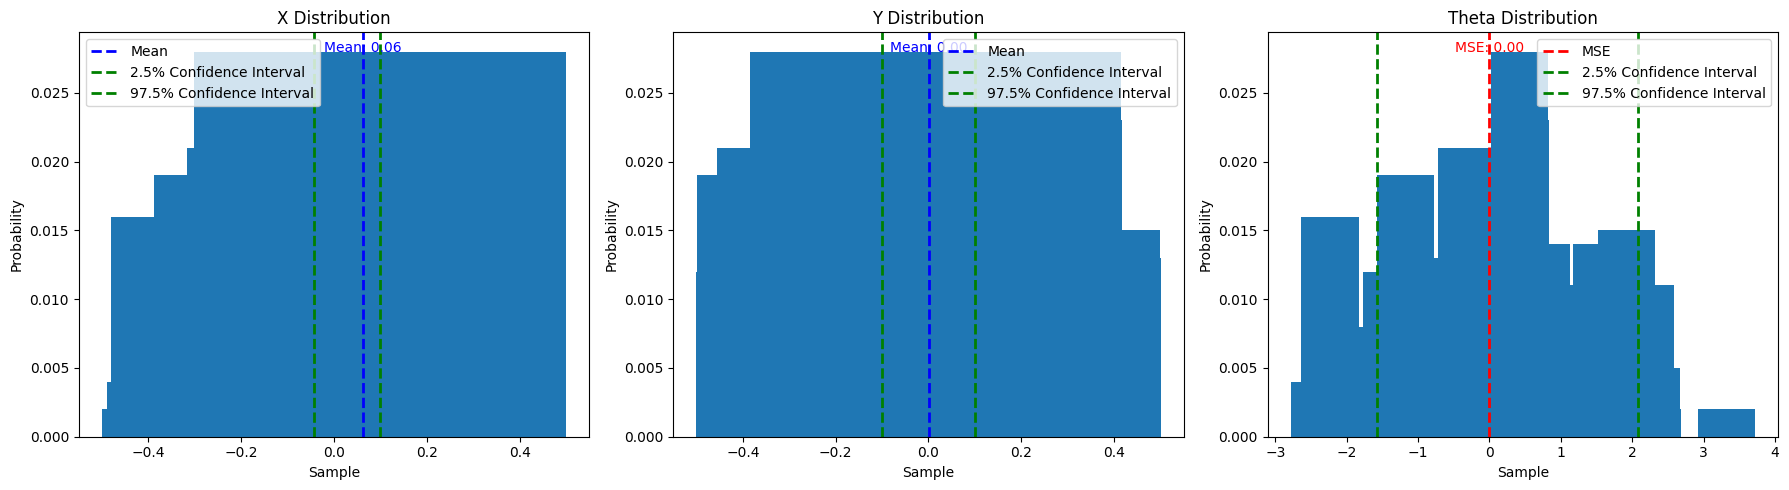

No. of iterations took place in order to reduce the MSE to the given threshold value is : 
 11


In [4]:
n_samples = 1000

# Initial conditions
x_prev = [np.full(n_samples, 0)]
y_prev = [np.full(n_samples, 0)]
theta_prev = [np.full(n_samples, 0)]
# Speed of the vehicle
v = 1
# Time step
delta_t = 0.1
# Number of steps
n_steps = 100
# Number of samples for the distribution
n_samples = 1000

# Lists to store the results
x_positions = [x_prev]
y_positions = [y_prev]
theta_values = [theta_prev]

# --------------------------------Initial Conditions Started----------------------------------------
# Accessing initial sample of change in heading angle from delta_theta_uniform_initial.txt.
observed_samples = []
with open('delta_theta_uniform_initial.txt', 'r') as file:
    for line in file:
        num_strings = line.strip().split()
        nums = [round(float(num), 25) for num in num_strings]
        observed_samples.extend(nums)

# Dictionary containing description of various types of distributions. 
# distributions = {
#     'Uniform': lambda: random.randint(-np.pi/3, np.pi/3),   # Uniform distribution
#     'Gaussian': lambda: round(np.random.normal(0, 1), 1),  # Gaussian Distribution
#     'Exponential': lambda: round(np.random.exponential(scale=1.0), 1),
#     'Binomial': lambda: np.random.binomial(n=10, p=0.5), #...
#     'Poisson': lambda: np.random.poisson(lam=3),         #...
#     'Beta': lambda: round(np.random.beta(a=2.0, b=5.0), 1), #...
#     'Gamma': lambda: round(np.random.gamma(shape=2.0, scale=1.0), 1),
#     'Log-Normal': lambda: round(np.random.lognormal(mean=0, sigma=1), 1),
#     'Triangular': lambda: round(np.random.triangular(left=-10, mode=0, right=10), 1),  # Triangular distribution
#     'Chi-Square': lambda: round(np.random.chisquare(df=2), 1),  # Chi-square distribution
#     'Pareto': lambda: round(np.random.pareto(a=2), 1)   # Pareto distributio
# }

# # Dictionary containing samples from various types of distributions. 
# samples = {name: [dist_func() for _ in range(1000)] for name, dist_func in distributions.items()}

# observed_samples = samples["Triangular"]


mean_observed_samples, std_observed_samples = staticalMeasures (observed_samples)
print ("Observed Samples : \n{}".format(observed_samples))
print ("Observed Mean : {}, Observed Std. Deviation : {}".format(round(mean_observed_samples,2), round(std_observed_samples,2)))

# Finding the underline distribution of observed_samples
dict_observed_samples = generateProbDictionary(observed_samples)
print ("Given Information <PARENT DISTRIBUTION>\n{}".format(dict_observed_samples))
print("The dictionary shows the sampled distribution of items along with the probability assigned to it.")

# --------------------------------Initial Conditions Ended-------------------------------------------

change_in_theta_distrib =  observed_samples
theta_prev, x_prev, y_prev = theta_prev[0], x_prev[0], y_prev[0]

# Doing the 1st iteration (hardcoding), so that MSE can be compared.
theta_final = [round(i + statistics.mean(theta_prev), 25) for i in change_in_theta_distrib]
x_new_distr, y_new_distr = kinematic_bicycle_model(statistics.mean(x_prev), statistics.mean(y_prev), change_in_theta_distrib)
    
new_samples = returnBootstrapSample(generateProbDictionary(change_in_theta_distrib), 1000)

dict_new_samples = generateProbDictionary(new_samples)
MSE = calculateMSE(generateProbDictionary(change_in_theta_distrib), dict_new_samples)
print("MSE :", MSE)
print(theta_final[:5])
print(x_new_distr[:5])
print(y_new_distr[:5])
plot_three_distributions(generateProbDictionary(x_new_distr), generateProbDictionary(y_new_distr), generateProbDictionary(theta_final), MSE, confidence_level=95)


# Updating the parameters.
change_in_theta_distrib = new_samples
theta_prev = theta_final
x_prev = x_new_distr
y_prev = y_new_distr


count = 1
# Set a reference MSE.
while (True):
    if (MSE <= 0.00000103) :
        # Set a threshold value of MSE.    
        break

    theta_final = [round(i + statistics.mean(theta_prev), 25) for i in change_in_theta_distrib]
    x_new_distr, y_new_distr = kinematic_bicycle_model(statistics.mean(x_prev), statistics.mean(y_prev), change_in_theta_distrib)

    # Modify change_in_theta_distrib, hence bootstraping the new list of sample from the found distribution; and then making a new distribution.
    new_samples = returnBootstrapSample(generateProbDictionary(change_in_theta_distrib), 1000)
    dict_new_samples = generateProbDictionary(new_samples)
    new_MSE = calculateMSE(generateProbDictionary(change_in_theta_distrib), dict_new_samples)
    if (new_MSE < MSE) :
        print("MSE : ", MSE)
        print(theta_final[:5])
        print(x_new_distr[:5])
        print(y_new_distr[:5])
        plot_three_distributions(generateProbDictionary(x_new_distr), generateProbDictionary(y_new_distr), generateProbDictionary(theta_final), MSE, confidence_level=95)
        MSE = new_MSE
    # Modify change_in_theta_distrib
    change_in_theta_distrib = new_samples

    # Updating x_prev and y_prev, so that it can be used as the input for the next iteration : 
    theta_prev = theta_final
    # print ("Check5")
    # print (theta_prev)
    x_prev = x_new_distr
    y_prev = y_new_distr
    count+=1
print("No. of iterations took place in order to reduce the MSE to the given threshold value is : \n", count)

Testing 3 subplots function.

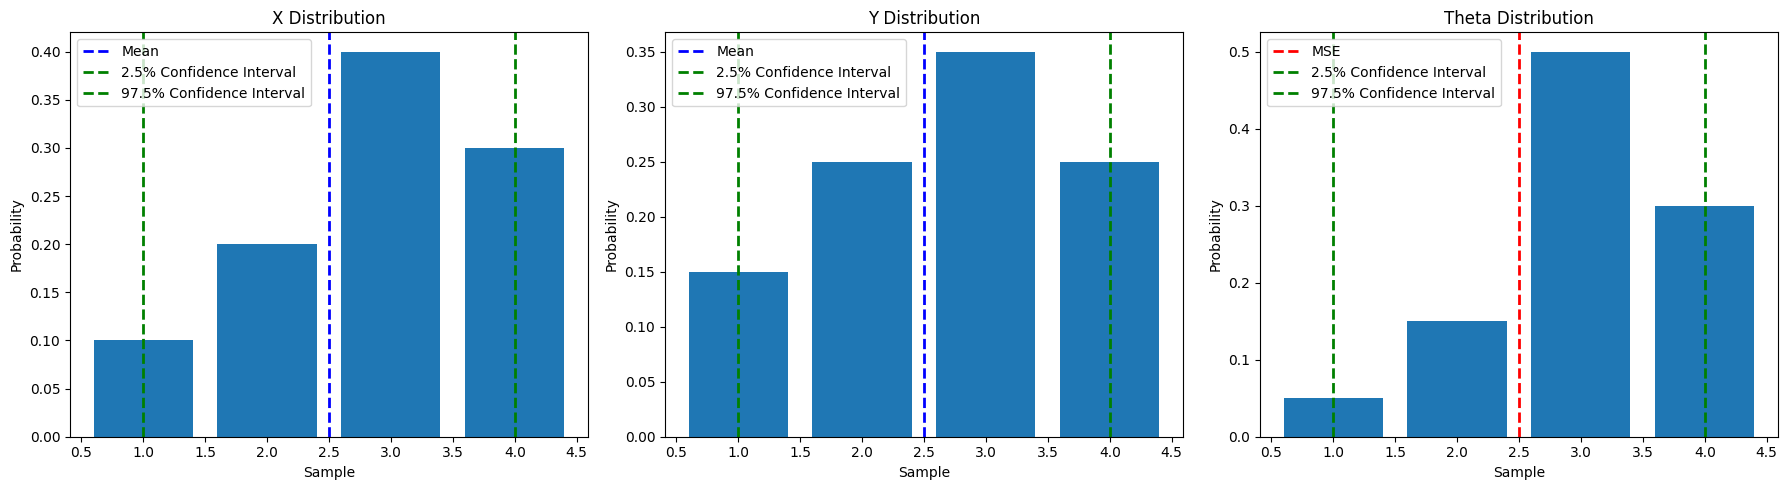

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_three_distributions(x_dict, y_dict, theta_dict, mse, confidence_level=95):
    def plot_single_distribution(ax, given_dict, title, mean_value=None, mse_value=None, confidence_level=95):
        numbers = list(given_dict.keys())
        probabilities = list(given_dict.values())
        
        ax.bar(numbers, probabilities)
        ax.set_title(title)
        ax.set_xlabel("Sample")
        ax.set_ylabel("Probability")
        
        if mean_value is not None:
            ax.axvline(x=mean_value, color='b', linestyle='--', linewidth=2, label="Mean")
        
        if mse_value is not None:
            ax.axvline(x=mse_value, color='r', linestyle='--', linewidth=2, label="MSE")
        
        cumulative_probabilities = np.cumsum(probabilities)
        lower_bound = (100 - confidence_level) / 2
        upper_bound = 100 - lower_bound
        
        lower_index = np.searchsorted(cumulative_probabilities, lower_bound / 100.0)
        upper_index = np.searchsorted(cumulative_probabilities, upper_bound / 100.0)
        
        if lower_index < len(numbers):
            ax.axvline(x=numbers[lower_index], color='g', linestyle='--', linewidth=2, label=f'{lower_bound}% Confidence Interval')
        if upper_index < len(numbers):
            ax.axvline(x=numbers[upper_index], color='g', linestyle='--', linewidth=2, label=f'{upper_bound}% Confidence Interval')
        
        ax.legend()
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot for x_dict
    x_mean = np.mean(list(x_dict.keys()))
    plot_single_distribution(axs[0], x_dict, "X Distribution", mean_value=x_mean, confidence_level=confidence_level)
    
    # Plot for y_dict
    y_mean = np.mean(list(y_dict.keys()))
    plot_single_distribution(axs[1], y_dict, "Y Distribution", mean_value=y_mean, confidence_level=confidence_level)
    
    # Plot for theta_dict
    plot_single_distribution(axs[2], theta_dict, "Theta Distribution", mse_value=mse, confidence_level=confidence_level)
    
    plt.tight_layout()
    plt.show()

# Example usage
x_dict = {1: 0.1, 2: 0.2, 3: 0.4, 4: 0.3}
y_dict = {1: 0.15, 2: 0.25, 3: 0.35, 4: 0.25}
theta_dict = {1: 0.05, 2: 0.15, 3: 0.5, 4: 0.3}
mse = 2.5

plot_three_distributions(x_dict, y_dict, theta_dict, mse)
